In [1]:
#import libraries and functions to load the data
import matplotlib.pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F

### Select Device (cpu, cuda, mps)

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
device="cpu" #Avoiding any possiblr complications with memory and other stuff
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 500
learning_rate = 0.01
num_epochs = 18
num_classes = 10

GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is cpu


### Creating Data Transforms for Preprocessing Data from MNIST

In [3]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)
test_data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

### Download the FASHION Dataset

In [4]:
train_dataset = datasets.FashionMNIST(root='./FashionMNIST', train=True, transform=train_data_transform, download=True)
test_dataset = datasets.FashionMNIST(root='./FashionMNIST', train=False, transform=test_data_transform, download=True)

train_dataset, valid_dataset = random_split(train_dataset, lengths=[55000, 5000])

### Creating DataLoaders to get mini-batches

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=0,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=0,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=0,
    shuffle=False
)

### Visualize the Data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([500, 1, 28, 28])


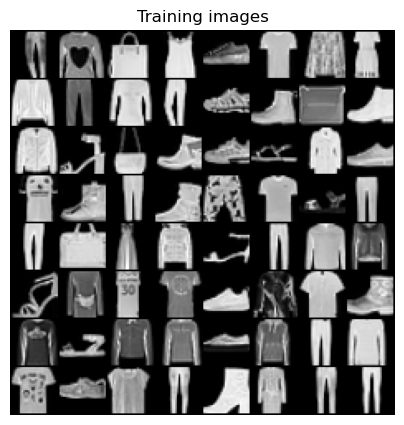

Labels = 
[[1 2 8 0 7 0 6 3]
 [4 1 2 1 5 9 8 9]
 [4 5 8 9 7 5 4 7]
 [0 9 1 9 1 0 5 1]
 [1 8 3 4 5 1 4 2]
 [5 3 0 0 7 6 6 9]
 [2 5 4 2 7 2 1 2]
 [0 7 0 1 9 3 1 1]]


In [6]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))


### Create the Convolutional Neural Network Model

In [7]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.cnn_features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

            
        )
        self.fc_features = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(288, 50),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(50, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn_features(x)
        x = self.fc_features(x)
        return x

### Helper function for Accuracy

In [8]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

In [9]:
def validate_da_stuff(model, dataloader, settings):
    model.eval()
    loss = 0
    for each in dataloader:
        inp, ver = each
        res = model(inp)
        loss += settings(res, ver).item()
    tot = len(dataloader)
    return loss/tot

### Training Loop

In [10]:
torch.manual_seed(random_seed)
model = CNN(num_classes=num_classes)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
train_loss = []
valid_loss = []
start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    running_loss = 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item()
        
        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    # Calculate training and validation loss for this epoch
    train_loss.append(running_loss/len(train_loader))
    val_loss_here = validate_da_stuff(model, test_loader, criterion)
    valid_loss.append(val_loss_here)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")


    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

Epoch: 001/018 | Batch: 100/110 | Loss: 0.6025
Epoch: 001 Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 76.544
Validation Accuracy: 76.120
Time elapsed so far: 0.56 min
Epoch: 002/018 | Batch: 100/110 | Loss: 0.5358
Epoch: 002 Learning Rate 0.01000000 -> 0.00900000
Train Accuracy: 81.438
Validation Accuracy: 81.300
Time elapsed so far: 1.12 min
Epoch: 003/018 | Batch: 100/110 | Loss: 0.4586
Epoch: 003 Learning Rate 0.00900000 -> 0.00900000
Train Accuracy: 84.164
Validation Accuracy: 84.200
Time elapsed so far: 1.67 min
Epoch: 004/018 | Batch: 100/110 | Loss: 0.3981
Epoch: 004 Learning Rate 0.00900000 -> 0.00810000
Train Accuracy: 85.467
Validation Accuracy: 85.400
Time elapsed so far: 2.23 min
Epoch: 005/018 | Batch: 100/110 | Loss: 0.3344
Epoch: 005 Learning Rate 0.00810000 -> 0.00810000
Train Accuracy: 86.855
Validation Accuracy: 87.040
Time elapsed so far: 2.80 min
Epoch: 006/018 | Batch: 100/110 | Loss: 0.3255
Epoch: 006 Learning Rate 0.00810000 -> 0.00729000
Train Accurac

In [11]:
model = model.eval()
ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Test Accuracy: 90.300


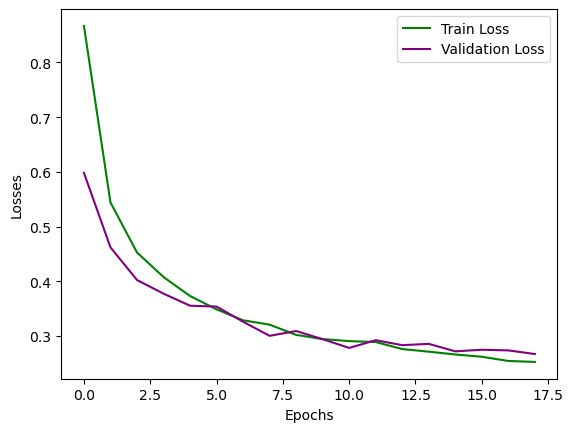

In [12]:
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(train_loss, 'green', label='Train Loss')
plt.plot(valid_loss, 'purple', label='Validation Loss')
plt.legend()
plt.show()

In [13]:
def render_matrix():
    c_m = torch.zeros(10, 10)
    with torch.no_grad():
        for data in test_loader:
            inp, verd = data
            res = model(inp)
            irrelavant, preds = torch.max(res.data, 1)
            for f, s in zip(verd.view(-1), preds.view(-1)):
                c_m[f.long(), s.long()] += 1
    return c_m

In [14]:
print("Confusion Matrix:", render_matrix())

Confusion Matrix: tensor([[805.,   3.,  14.,  22.,   6.,   1., 138.,   0.,  10.,   1.],
        [  0., 975.,   0.,  15.,   4.,   0.,   5.,   0.,   1.,   0.],
        [  9.,   0., 858.,  11.,  69.,   0.,  50.,   0.,   3.,   0.],
        [ 11.,   2.,   7., 912.,  43.,   0.,  24.,   0.,   1.,   0.],
        [  2.,   1.,  37.,  25., 899.,   1.,  33.,   0.,   2.,   0.],
        [  0.,   0.,   0.,   0.,   0., 988.,   0.,   5.,   0.,   7.],
        [ 90.,   0.,  59.,  22., 135.,   0., 681.,   0.,  13.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  18.,   0., 957.,   1.,  24.],
        [  0.,   0.,   2.,   4.,   1.,   2.,   0.,   1., 990.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   5.,   0.,  29.,   1., 965.]])
